In [24]:
%matplotlib inline

## ACTIVIDAD 2. Segmetación

### Resumen

El problema escogido para la realización de esta práctica es la segmentación de imagenes, especificamente la identificación regiones del rostro de personas usando Segmentación Superervisada y Segmentación no supervisada (detección de areas con contraste de color en la imagen).

Para la resolución del problema se han revisado y aplicado técnicas basadas en la aplicación de filtros espaciales y segmentación. Algunas de estas técnicas fueron detalladas en clase y otras no. Para resolver el problema se han establecido diferentes pasos, de forma análoga a las soluciones de la bibliografía. Para cada uno de los pasos se han analizado diferentes métodos de resolución, con la finalidad de determinar cual de ellos ofrece mejores resultados. 


### PASO 0: Importación de librerias skimage, cv2, matplotlib y numpy para el procesamiento del ejercicio.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import cv2


### PASO 1: Creación rutina despliege imagenes, lectura y preparación de la imagen (preprocesamiento con aplicación de filtros espaciales)

In [23]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

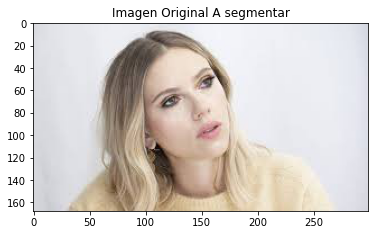

In [24]:
# importamos imagen a tratare
from skimage import io
image = io.imread('scarlet5.jpg') 
plt.title("Imagen Original a segmentar")
plt.imshow(image)

### 1.2 Lectura de las imagenes Ground Truth generadas con GIMP, para realizar la evaluación de la segmentación usando Indice Jaccard

(Text(0.5, 1.0, ' Imagen Ground Truth - GIMP Segmentación Random Walker'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

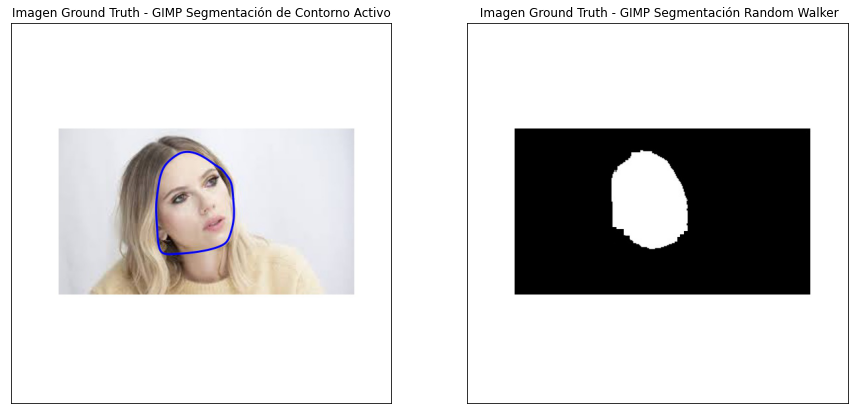

In [50]:
image_contorno_gt = io.imread('image_contorno_gimp.jpg') 
image_random_gt = io.imread('image_random_gimp.jpg') 
plt.figure(figsize=(15,15))
plt.subplot(1,2,1),plt.imshow(image_contorno_gt , cmap='gray');plt.title('Imagen Ground Truth - GIMP Segmentación de Contorno Activo'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(image_random_gt);plt.title(' Imagen Ground Truth - GIMP Segmentación Random Walker'), plt.xticks([]), plt.yticks([])

El siguiente paso sería convertir la imagen a escala de grises con  Blurring (Image Smoothing) Bilateral Filter, por que he validado que la resolución tanto del Active countour segmentation y Random Walker, funcionan mejor que el rgb2gray.

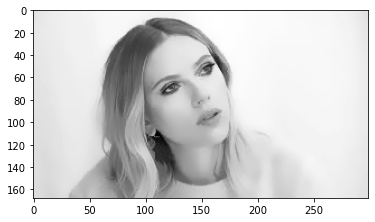

In [26]:
bilateralBlurGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Conversión de la imagen a escala de grises
image_gray = cv2.bilateralFilter(bilateralBlurGray, 13, 15, 15) #Image Blurring (Image Smoothing) Bilateral Filter
plt.imshow(image_gray, cmap='gray');

## Paso 2: Segmentación Supervisada.

La segmentación supervisada, como dice su nombre, es realizar un proceso de segmentación de una región de la imagen, elegida o seleccionada por el usuario, usando distintos metodos. En este caso usaremos dos métodos de segmentación que funcionan con principios completamente diferentes. El metodo Active contour segmentation y el algoritmo Random walker.

### 2.1 Metodo de segmentación Active Contour segmentation

El metodo de Segmentación de Contorno Activo (comúnmente llamado Snake) consiste en una curva elástica aproximada
que, colocada sobre una imagen, empieza a deformarse a partir de una forma inicial con el fin
de delimitar las regiones de interés en la imagen. Esta deformación se produce mediante la
aplicación de fuerzas internas, intrínsecas al Snake y que controlan la suavidad de la curva, así
como mediante fuerzas externas, procedentes de la imagen bajo tratamiento, que empujan al
Snake hacia las características salientes de la imagen. 
http://bibing.us.es/proyectos/abreproy/70265/fichero/Cap%C3%ADtulo+3.pdf

A la función circle_points le entregamos las coordenadas del centro del area del rostro que deseamos segmentar y el diametro de la circunferencia del area a segmentar.  En este caso la resolución es 160 por 250, especificamos 80, 40, con un diametro de 70.

In [51]:
def circle_points(resolution, center, radius):
    """ Generate points defining a circle on an image. """
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [80, 140], 70)[:-1]

Dibujamos el circulo definido en la imagen, para representar el area a segmentar. 

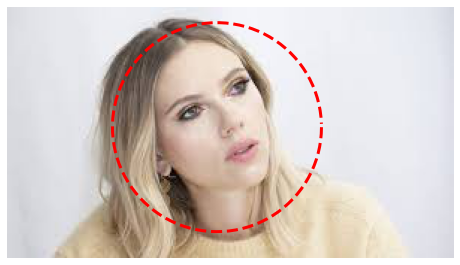

In [52]:
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

Luego, el algoritmo segmentara la zona del rostro adscrito a la circunferecnia, del resto de la imagen ajustando una curva cerrada a los bordes del rostro.
Podemos modificar los parámetros llamados alfa y beta. Los valores más altos de alfa harán que esta "serpiente" se contraiga más rápido, mientras que la beta hará que la serpiente sea más suave.

Luego de probar varias opciones, he comprovado que incluir una funcion gaussian a la imagen a tratar, tiene mejor resultados 

C:\Users\N63422\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  


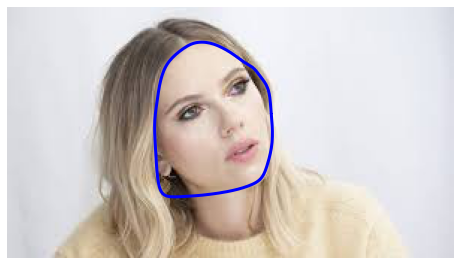

In [54]:
from skimage.filters import gaussian
snake = seg.active_contour(gaussian(image_gray, 2), points,alpha=0.06,beta=0.9)
fig, ax = image_show(image)
#ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);
fig.savefig('image_contorno_salida.jpg') 


Imagen con el rostro segmentado con el metodo Segmentación de Contorno Activo. 

### 2.2 Metodo de segmentación Random walker
El algoritmo Ramdom Walker determina la segmentación de una imagen de un conjunto de marcadores que etiquetan varias fases (2 o más). Una ecuación de difusión anisotrópica se resuelve con trazadores iniciados en la posición de los marcadores. El coeficiente de difusividad local es mayor si los píxeles vecinos tienen valores similares, por lo que la difusión es difícil a través de gradientes altos. La etiqueta de cada píxel desconocido se atribuye a la etiqueta del marcador conocido que tiene la mayor probabilidad de ser alcanzado primero durante este proceso de difusión.
https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_random_walker_segmentation.html

El algoritmo Random Walker espera una imagen de etiqueta como entrada. Entonces tendremos el círculo más grande que abarca toda el area del rostro a segmentar y otro círculo más pequeño cerca de la mitad del area a segmentar.

Utilizaremos las coordenadas con las que generamos el circulo inicial del Active Countour.


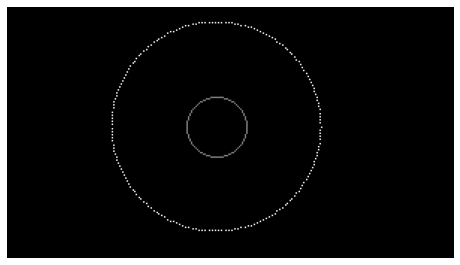

In [55]:
image_labels = np.zeros(image_gray.shape, dtype=np.uint8)

indices = draw.circle_perimeter(80,140,20)#from here
image_labels[indices] = 1
image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2
image_show(image_labels);

Ahora utilizamos Random Walker, para ver la segmentación de la imagen, en este caso la región del rostro.  Para ir afinando los detalles de los bordes, podemos sintonizar el parámetro beta hasta obtener los resultados deseados. Después de varios intentos, un valor de 3000 funciona razonablemente bien. La primera imagen con un alfa de 0.3 segmenta perfectamente el rostro deseado, pero la segunda imagen generada con alpha 1, nos permite obtener una segmentación binaria, que nos servira para comparar con el ground truth generado con GIMP. 

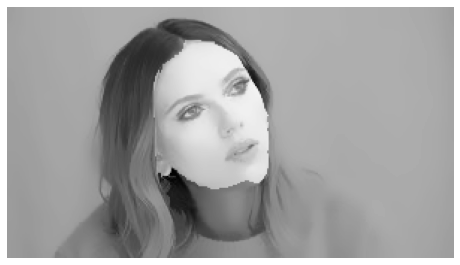

In [56]:
image_segmented = seg.random_walker(image_gray, image_labels, beta = 3000)
# Check our results
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.3, cmap='gray');

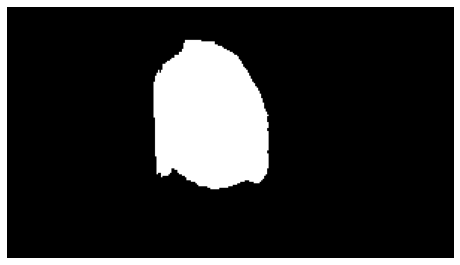

In [57]:
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=1, cmap='gray');
fig.savefig('image_random_salida.jpg') 

### 2.3 Validación segmentación Random Forrest con Ground Truth generado con GIMP, usando Indice Jaccard 

(Text(0.5, 1.0, ' Imagen Ground Truth generada por GIMP'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

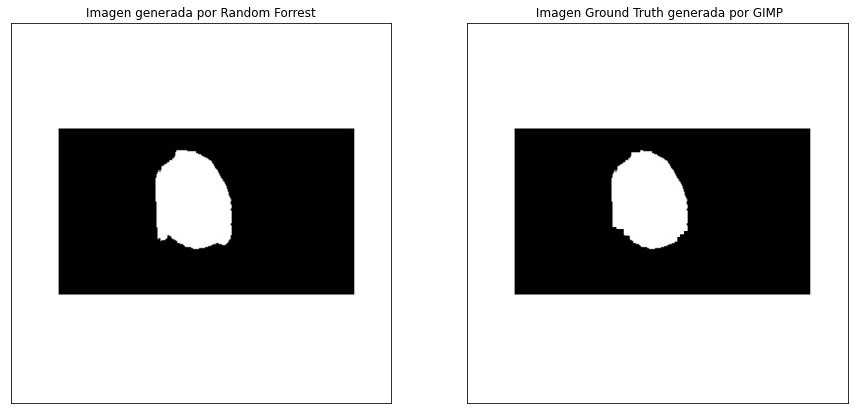

In [58]:
image_salida = io.imread('image_random_salida.jpg') 
plt.figure(figsize=(15,15))
plt.subplot(1,2,1),plt.imshow(image_salida);plt.title('Imagen generada por Random Forrest'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(image_random_gt);plt.title(' Imagen Ground Truth generada por GIMP'), plt.xticks([]), plt.yticks([])

## Paso 3 Segmentación No Supervisada Clustering (K-Means

La segmentación no supervisada no requiere conocimientos previos de la imagen y no es necesario la participación de un persona que parametrice el area de la imagen a tratar. La segmentación no supervisada puede dividir la imagen en varias subregiones, por lo que la imagen en lugar de tener millones de píxeles, solo tendra las regiones que nosotros definamos en el parametro del cluster.


In [59]:
# leemos la imagen a tratar y mostramos
pic = plt.imread('scarlet5.jpg')/255  # dividing by 255 to bring the pixel values between 0 and 1
print(pic.shape)

(168, 299, 3)


In [60]:
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(50232, 3)

 Importamos las librerias necesarias para ejecutar el algoritmo KMeans

In [61]:
from sklearn.cluster import KMeans

Generamos el cluster de la imagen, en este caso con 2 cluster para representar mejor la imagen en 2 escalas de grises

In [62]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

Generamos el custer de la imagen y la mostramos

In [63]:
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])

(Text(0.5, 1.0, ' Imagen segmentada utilizando el metodo K-Means'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

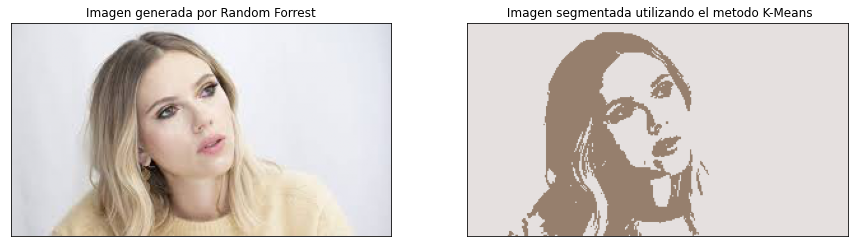

In [64]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1),plt.imshow(pic);plt.title('Imagen generada por Random Forrest'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(cluster_pic);plt.title(' Imagen segmentada utilizando el metodo K-Means'), plt.xticks([]), plt.yticks([])